# Kanji OCR Project

# CT255 - Nhóm 01

- **Student Name**: Nguyễn Xuân Nghĩa
- **Student ID**: B1906528

- **Student Name**: Nguyễn Thanh An
- **Student ID**: B1906424

# Tải các phụ thuộc

In [1]:
import tensorflow as tf
from tensorflow import keras
import imageio.v3 as iio
import numpy as np
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import keras_tuner as kt
import os
import chardet

# Load dataset

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Đường dẫn đến thư mục chứa dữ liệu 
base_path = 'kkanji2'

# Sử dụng image_dataset_from_directory để tạo dataset từ thư mục
data = tf.keras.utils.image_dataset_from_directory(
    base_path,
    color_mode="grayscale",
    label_mode="categorical",
    image_size=(28, 28),  # Kích thước ảnh mong muốn
    batch_size=128
)

Found 140424 files belonging to 3832 classes.


In [4]:
# Lấy tên của các lớp (class) từ dataset
class_names = data.class_names

# Lấy một batch từ dataset
batch = next(iter(data))

# Hiển thị thông tin về shape của ảnh và nhãn trong batch
print("Shape của ảnh trong batch:", batch[0].shape)
print("Shape của nhãn trong batch:", batch[1].shape)

Shape của ảnh trong batch: (128, 28, 28, 1)
Shape của nhãn trong batch: (128, 3832)


# Show data

Unscaled Data:
min: 0.0 max: 255.0


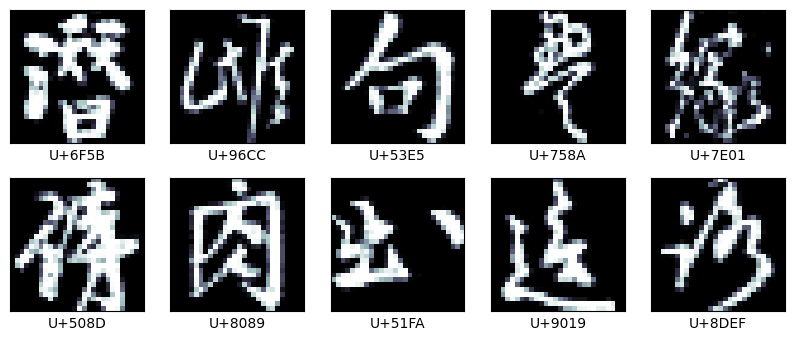

In [5]:
# Lấy dữ liệu hình ảnh từ batch
characters = batch[0]

# In ra thông tin về dữ liệu không được tỉ lệ (unscaled data)
print('Unscaled Data:')
print('min:', tf.reduce_min(characters).numpy(), 'max:', tf.reduce_max(characters).numpy())

# Tạo một biểu đồ để hiển thị 10 hình ảnh và nhãn tương ứng
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Hiển thị hình ảnh
    plt.imshow(characters[i], cmap=plt.cm.bone)

    # Thêm nhãn cho hình ảnh dựa trên nhãn trong batch
    plt.xlabel(class_names[np.where(batch[1][i] == 1)[0][0]])

# Hiển thị biểu đồ
plt.show()

# Dữ liệu tiền xử lý

In [6]:
# Tỉ lệ hóa dữ liệu bằng cách chia cho 255
data = data.map(lambda x, y: (x / 255, y))

# Chuyển đổi dữ liệu thành một iterator có thể sử dụng trong quá trình lặp
scaled_iterator = data.as_numpy_iterator()

In [7]:
# Lấy một batch từ iterator đã được tỉ lệ hóa
batch = scaled_iterator.next()

Scaled Data:
min: 0.0 max: 1.0


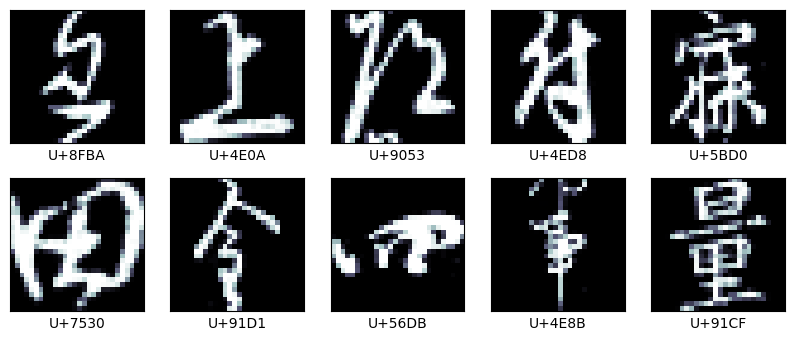

In [8]:
# Lấy dữ liệu đã được tỉ lệ hóa từ batch
characters = batch[0]

# Hiển thị thông tin về dữ liệu sau khi đã được tỉ lệ hóa
print('Scaled Data:')
print('min:', characters.min(), 'max:', characters.max())

# Tạo và hiển thị một số hình ảnh từ batch đã được tỉ lệ hóa
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(characters[i], cmap=plt.cm.bone)
    plt.xlabel(class_names[np.where(batch[1][i] == 1)[0][0]])

# Hiển thị đồ thị
plt.show()

In [9]:
# Phân chia tỷ lệ dữ liệu cho việc huấn luyện, kiểm định và kiểm thử
train_share = .7
val_share = .2
test_share = .1

In [10]:
# Tính toán kích thước tương ứng của từng phần
train_size = int(len(data) * train_share)
val_size = int(len(data) * val_share)
test_size = int(len(data) * test_share)

In [11]:
# Lấy dữ liệu cho từng phần
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

# Định nghĩa mô hình


In [12]:
# Định nghĩa các callbacks cho quá trình huấn luyện mô hình
early_stopping = tf.keras.callbacks.EarlyStopping(patience=4)
# Callback dừng sớm nếu không có cải thiện trong 4 epochs liên tiếp.

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
# Callback giảm learning rate nếu không có cải thiện trong 2 epochs liên tiếp trên tập kiểm định.
# Factor = 0.2 giảm learning rate xuống 20% của giá trị hiện tại.
# Min_lr = 0.001 giữ cho learning rate không thể giảm xuống dưới 0.001.

In [13]:
#def model_builder(hp):
#    model = keras.Sequential()
#    model.add(keras.layers.Flatten(input_shape=(28,28,1)))
#
#
#    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
#    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=1000, step=100)
#    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=1000, step=100)
#    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#    model.add(keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
#   model.add(keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
#    model.add(keras.layers.Dense(len(class_names), activation='softmax'))
#    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy())
    
#    return model  # Thêm dòng này để trả về mô hình

In [14]:
#tuner = kt.Hyperband(model_builder, objective='accuracy', max_epochs=10, factor=3, directory='dir', project_name='kanji-ocr-tuned')


In [15]:
#tuner.search(data, epochs=50, validation_data=val_data, callbacks=[early_stopping])

In [16]:
#best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
#tuned_model = tuner.hypermodel.build(best_hps)


In [17]:
# Sau đó, bạn cần fit mô hình với dữ liệu
#tuned_model.fit(...)

In [18]:
# Xây dựng mô hình Convolutional Neural Network (CNN) sử dụng Keras Sequential API.
model = keras.Sequential()

In [19]:
# Layer Conv2D đầu tiên với 16 bộ lọc, kích thước (3,3), activation là 'relu', và input_shape là (28,28,1).
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)))
# Layer MaxPooling2D giúp giảm kích thước của feature maps.
model.add(keras.layers.MaxPooling2D())

# Layer Conv2D thứ hai với 32 bộ lọc và kích thước (3,3), activation là 'relu'.
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
# Layer MaxPooling2D giúp giảm kích thước của feature maps.
model.add(keras.layers.MaxPooling2D())

# Layer Conv2D thứ ba với 16 bộ lọc và kích thước (3,3), activation là 'relu'.
model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
# Layer MaxPooling2D giúp giảm kích thước của feature maps.
model.add(keras.layers.MaxPooling2D())

# Layer Dropout để ngăn chặn việc quá mức giữ thông tin và giảm overfitting.
model.add(keras.layers.Dropout(0.25))

# Layer Flatten để chuyển đổi feature maps thành một vector để đưa vào các layer fully connected.
model.add(keras.layers.Flatten())

# Layer Dense với 512 units và activation là 'relu'.
model.add(keras.layers.Dense(512, activation='relu'))
# Layer output với số units bằng số lượng class và activation là 'softmax'.
model.add(keras.layers.Dense(len(class_names), activation='softmax'))

In [20]:
# Compile mô hình với optimizer là 'adam', loss function là Categorical Crossentropy, và độ đo là 'accuracy'.
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Hiển thị thông tin tổng quan về kiến trúc của mô hình.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 16)          4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 16)          0

# Huấn luyện mô hình

In [21]:
# Định nghĩa đường dẫn cho TensorBoard logs.
logdir='logs'

In [22]:
# Tạo callback TensorBoard để theo dõi và ghi log cho TensorBoard.
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [23]:
# Huấn luyện mô hình với dữ liệu huấn luyện và validation_data, sử dụng callback TensorBoard và reduce_lr.
# verbose=1 để hiển thị thông tin về quá trình huấn luyện.
hist = model.fit(train_data, epochs=40, validation_data=val_data, callbacks=[tensorboard_callback, reduce_lr], verbose=1)

Epoch 1/40
768/768 [==============================] - 108s 139ms/step - loss: 6.1543 - accuracy: 0.0712 - val_loss: 5.2231 - val_accuracy: 0.1787 - lr: 0.0010
Epoch 2/40
768/768 [==============================] - 106s 137ms/step - loss: 5.1198 - accuracy: 0.1535 - val_loss: 4.6177 - val_accuracy: 0.2526 - lr: 0.0010
Epoch 3/40
768/768 [==============================] - 137s 179ms/step - loss: 4.7225 - accuracy: 0.1914 - val_loss: 4.3121 - val_accuracy: 0.2960 - lr: 0.0010
Epoch 4/40
768/768 [==============================] - 128s 166ms/step - loss: 4.4424 - accuracy: 0.2172 - val_loss: 4.1219 - val_accuracy: 0.3187 - lr: 0.0010
Epoch 5/40
768/768 [==============================] - 132s 172ms/step - loss: 4.2429 - accuracy: 0.2367 - val_loss: 3.8734 - val_accuracy: 0.3483 - lr: 0.0010
Epoch 6/40
768/768 [==============================] - 140s 182ms/step - loss: 4.0794 - accuracy: 0.2518 - val_loss: 3.7936 - val_accuracy: 0.3603 - lr: 0.0010
Epoch 7/40
768/768 [==========================

# Run tests and export

In [24]:
# Lưu mô hình đã được huấn luyện vào một file có tên 'checkpoint-kanji-ocr-model.h5' trong thư mục 'models'.
model.save(os.path.join('models', 'checkpoint-kanji-ocr-model.h5'))

# Tải mô hình từ file đã lưu để sử dụng hoặc đánh giá.
loaded_model = keras.models.load_model(os.path.join('models', 'checkpoint-kanji-ocr-model.h5'))

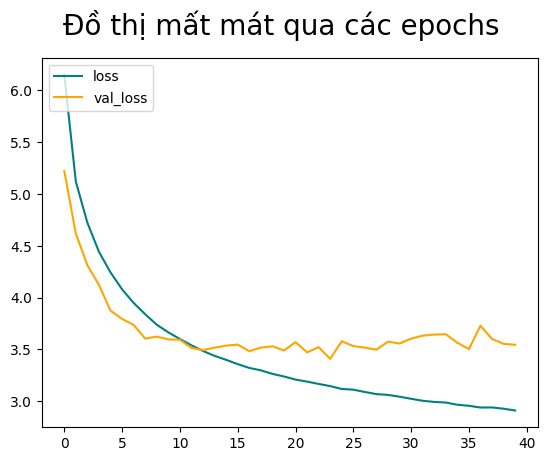

In [25]:
# model.save(os.path.join('models', 'checkpoint-kanji-ocr-model.h5'))
# Tạo đồ thị để hiển thị sự thay đổi của hàm mất mát (loss) và hàm mất mát trên tập validation qua các epochs.
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')  # Biểu diễn hàm mất mát trên tập huấn luyện.
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')  # Biểu diễn hàm mất mát trên tập validation.
fig.suptitle('Đồ thị mất mát qua các epochs', fontsize=20)
plt.legend(loc="upper left")  # Hiển thị chú thích.
plt.show()


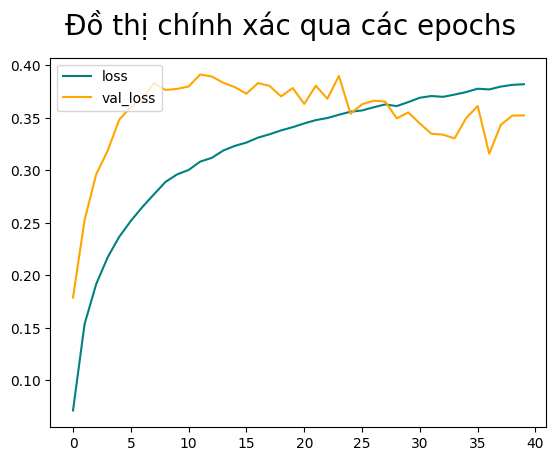

In [26]:
# Giả sử hist là biến chứa lịch sử huấn luyện của mô hình
fig = plt.figure()

# Vẽ đồ thị chính xác trên tập huấn luyện và tập validation
plt.plot(hist.history['accuracy'], color='teal', label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_loss')

# Thêm tiêu đề và nhãn cho trục x, y
fig.suptitle('Đồ thị chính xác qua các epochs', fontsize=20)

# Hiển thị chú thích và đặt nó ở vị trí trên bên trái
plt.legend(loc="upper left")
plt.show()   # Hiển thị biểu đồ

In [27]:
# Tạo các đối tượng đo lường đánh giá
pre = keras.metrics.Precision()  # Precision - Chính xác
re = keras.metrics.Recall()  # Recall - Nhớ
acc = keras.metrics.CategoricalAccuracy()  # Categorical Accuracy - Độ chính xác đa lớp

In [28]:
# Lặp qua các batch trong tập kiểm thử và cập nhật các chỉ số đánh giá
for batch in test_data.as_numpy_iterator():
    # Tách dữ liệu và nhãn từ batch
    X, y = batch
    
    # Dự đoán đầu ra của mô hình cho dữ liệu kiểm thử
    yhat = model.predict(X)
    
    # Cập nhật các chỉ số đánh giá với giá trị dự đoán và nhãn thực tế
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

4/4 [==============================] - 0s 10ms/step


In [29]:
# In các chỉ số đánh giá độ chính xác của mô hình
print(f'Chính xác (Precision): {pre.result().numpy()}, Nhớ (Recall): {re.result().numpy()}, Độ chính xác (Accuracy): {acc.result().numpy()}')

Chính xác (Precision): 0.9063071012496948, Nhớ (Recall): 0.14213016629219055, Độ chính xác (Accuracy): 0.35313934087753296


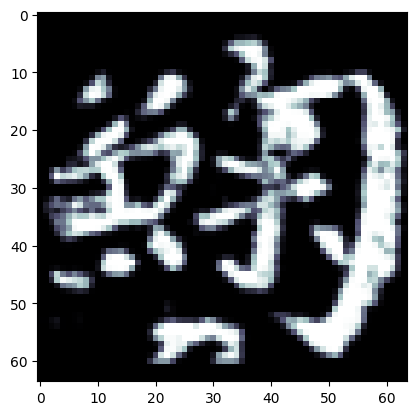

In [30]:
# Đọc hình ảnh từ đường dẫn
img = iio.imread('kkanji2/U+4C61/e6eeb23552e1a21c.png')

# Hiển thị hình ảnh
plt.imshow(img, cmap=plt.cm.bone)

# Hiển thị biểu đồ
plt.show()


In [31]:
resize = img
# resize = tf.image.resize(img, (127, 128))
# plt.imshow(resize, cmap=plt.cm.bone)
# plt.show()

Found 140424 files belonging to 3832 classes.


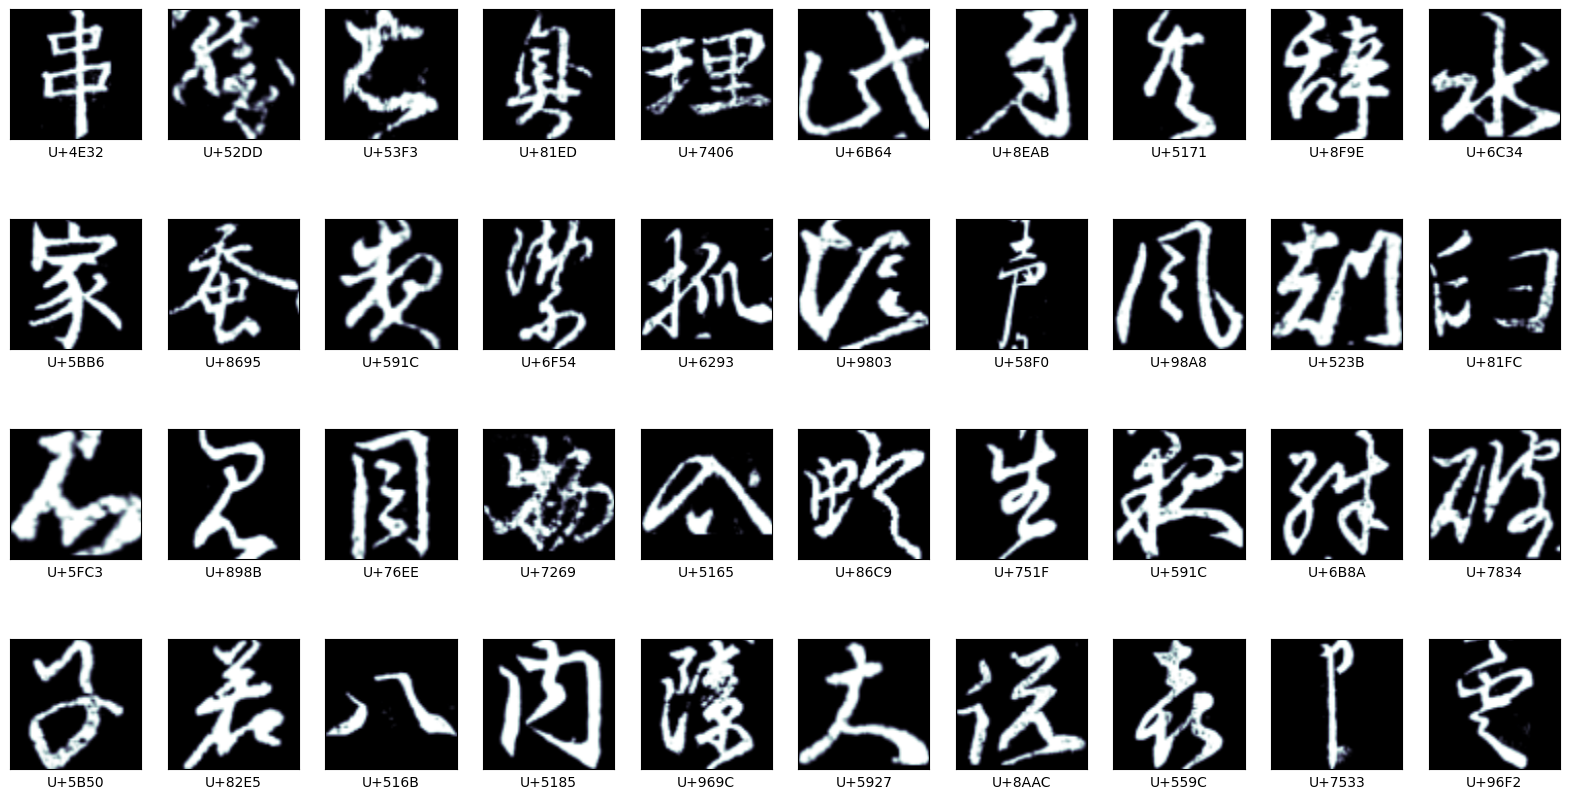

In [32]:
# Tạo đối tượng dữ liệu từ thư mục hình ảnh
new_data = keras.utils.image_dataset_from_directory('kkanji2', label_mode="categorical", 
                                                    color_mode="grayscale", image_size=(127, 128), batch_size=70)

# Chuyển đổi dữ liệu thành dạng numpy
it = new_data.map(lambda x, y: (x / 255, y)).as_numpy_iterator()
batch = it.next()

# Vẽ các hình ảnh từ batch
plt.figure(figsize=(20, 10))
for i in range(40):
    try:
        plt.subplot(4, 10, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        # Hiển thị hình ảnh
        plt.imshow(batch[0][i], cmap=plt.cm.bone)
        
        # Thêm nhãn với tên lớp tương ứng
        plt.xlabel(new_data.class_names[np.where(batch[1][i] == 1)[0][0]])
    except:
        print('', end='')

# Tăng khoảng cách giữa các hình ảnh
plt.subplots_adjust(hspace=0.5)

# Hiển thị biểu đồ
plt.show()

1/1 [==============================] - 0s 20ms/step


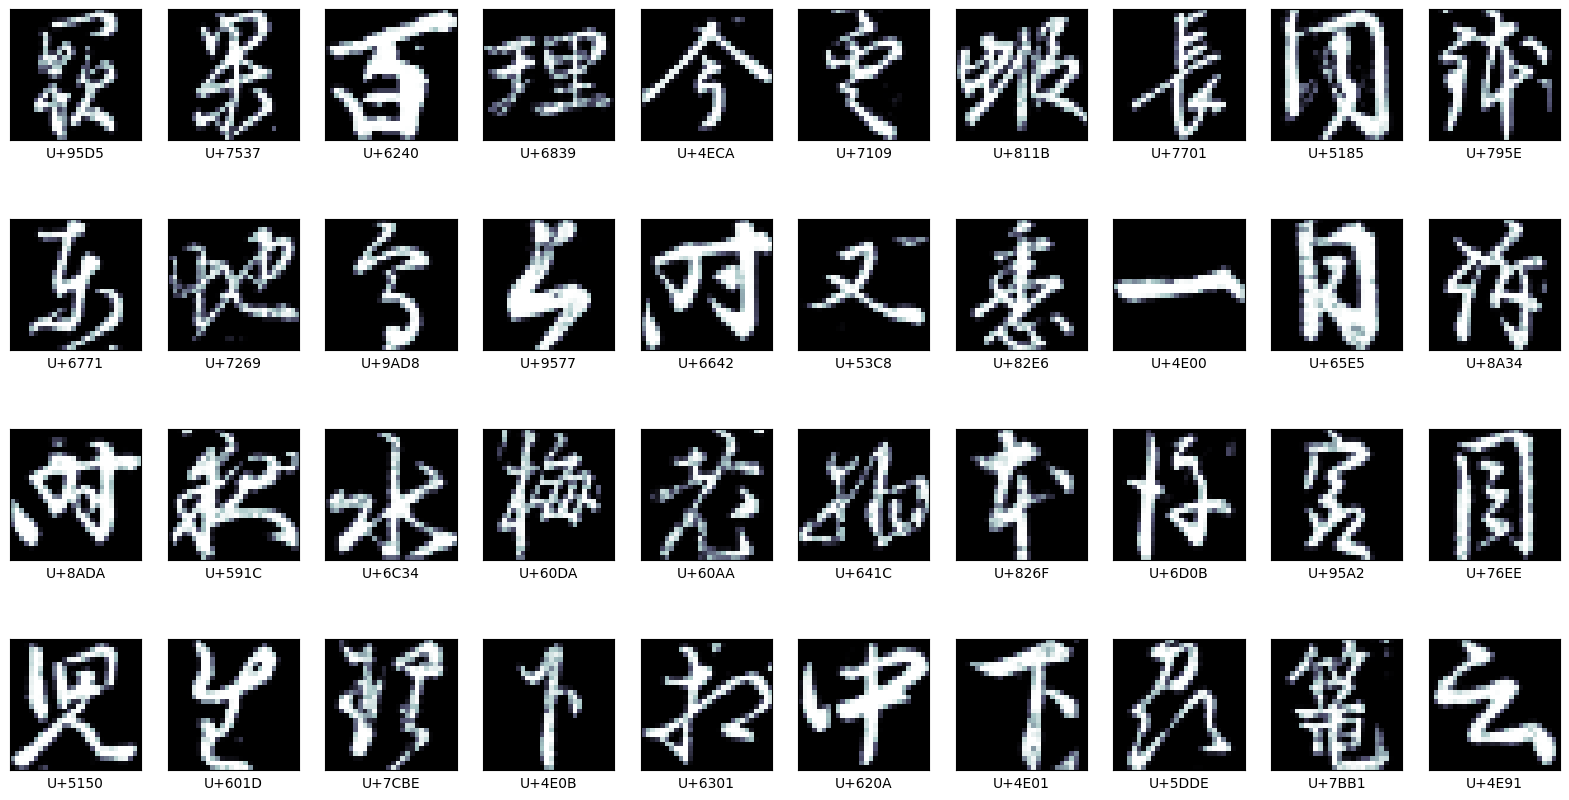

In [33]:
# Chuyển đổi dữ liệu thành dạng numpy
it = new_data.map(lambda x, y: (x / 255, y)).as_numpy_iterator()
batch = it.next()

# Vẽ các hình ảnh từ batch
plt.figure(figsize=(20, 10))
for i in range(40):
    try:
        plt.subplot(4, 10, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        # Thay đổi kích thước hình ảnh để phù hợp với mô hình
        resized_image = tf.image.resize(batch[0][i], (28, 28))
        
        # Hiển thị hình ảnh
        plt.imshow(resized_image, cmap=plt.cm.bone)
        
        # Dự đoán nhãn cho hình ảnh
        yhat = loaded_model.predict(np.expand_dims(resized_image, axis=0))
        
        # Thêm nhãn với tên lớp tương ứng
        plt.xlabel(new_data.class_names[np.where(yhat[0] == np.max(yhat[0]))[0][0]])
    except:
        print('', end='')

# Tăng khoảng cách giữa các hình ảnh
plt.subplots_adjust(hspace=0.5)

# Hiển thị biểu đồ
plt.show()

In [34]:
model.save(os.path.join('models', 'kanji-ocr-model.h5'))

In [35]:
loaded_model = keras.models.load_model(os.path.join('models', 'kanji-ocr-model.h5'))
print(loaded_model)